# **Purchasing Intention Prediction**

In this project, I'll explore the Online Shoppers Purchasing Intention Dataset available [here](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#). The aim of this project is to understand the data and predict whether a visitor will make a purchase or not.

# **Import libraries**

The first step is to import the necessary libraries I'll use in this project. For working with the Artificial Neural Network, I'll use Keras with Tensorflow backend.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import tensorflow 
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

# **Import dataset**

Next step is to import the dataset and get basic information from it.

In [2]:
dataset = pd.read_csv('dataset.csv')

In [3]:
dataset.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
4143,2,46.333333,0,0.0,11,177.404762,0.016667,0.038194,0.0,0.0,May,3,2,5,4,Returning_Visitor,False,False
3560,0,0.000000,0,0.0,13,252.000000,0.000000,0.061538,0.0,0.0,May,2,2,8,3,Returning_Visitor,False,False
8953,0,0.000000,0,0.0,58,3178.500000,0.000000,0.015789,0.0,0.0,Nov,2,2,9,2,Returning_Visitor,False,True
7319,11,604.730000,0,0.0,63,1276.843158,0.000000,0.006712,0.0,0.0,Jul,2,2,8,6,New_Visitor,False,True
11825,8,122.041667,0,0.0,14,338.791667,0.000000,0.025000,0.0,0.0,Dec,2,2,7,3,Returning_Visitor,False,False


Let's see if there are any null values.

In [4]:
dataset.isnull()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12326,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12327,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12328,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Seems like all cells are filled and there are no missing values. Also, the time spent on a certain type of page owuld generally correlate with the number of that type of pages visited. Hence, I'll drop the number of each type of page visited and just keep the duration columns. I'll also check the description of the columns to understand the range of each column.

In [6]:
dataset.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


The mean of each column is very varied from one another and hence scaling should help with it. Considering that Revenue is the target column, I'll split the dataset into test and train sets.

In [7]:
X = dataset.iloc[:,:-1]
Y = dataset.iloc[:,-1]

In [8]:
X.shape

(12330, 17)

# **Data analysis and visualization**

Let's take a deep dive and try to understand the dataset through visualizations.

## **Target column**

The first step is to take a look at the distribution of the data between the two classes.

In [10]:
target_distribution = Y.value_counts()
print(target_distribution)

False    10422
True      1908
Name: Revenue, dtype: int64


In [11]:
print(target_distribution.keys().tolist(), target_distribution.tolist())

[False, True] [10422, 1908]


Text(0.5, 1.0, 'Count of visitors based on revenue generated')

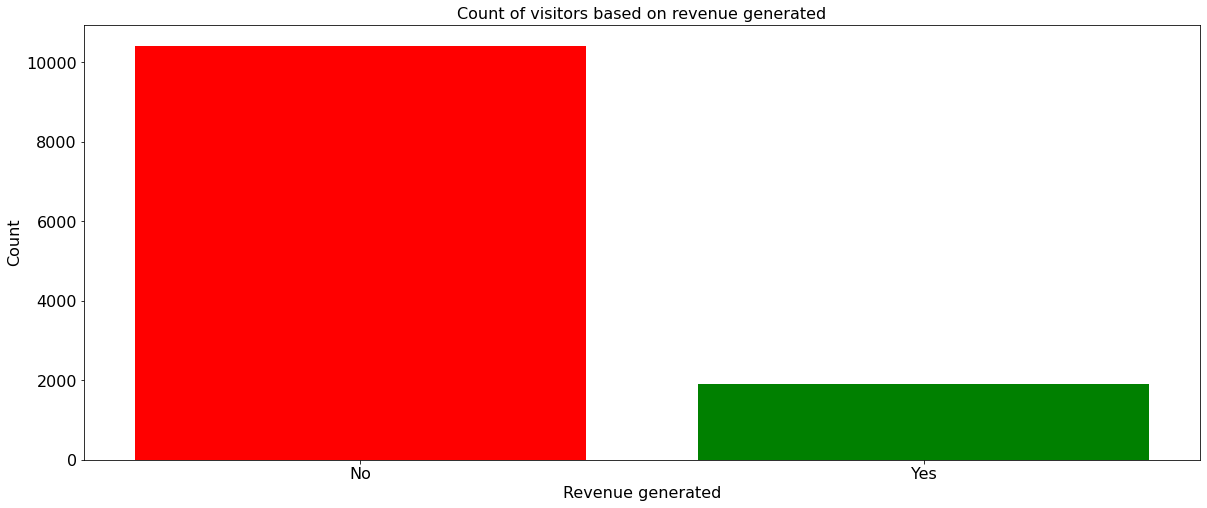

In [12]:
plt.figure(figsize = (20, 8))

plt.bar(target_distribution.keys().tolist(), target_distribution.tolist(), color = ['red', 'green'])

plt.xlabel('Revenue generated', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.xticks([0.0, 1.0], ['No', 'Yes'], fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Count of visitors based on revenue generated', fontsize = 16)

As is clear from the bar plot above, the dataset includes majority of feature values that resulted in no revenue generation. The dataset is highly unbalanced and this is where we'd have to create an efficient model that can still classify between the two classes.

### **Correlation matrix**

I'll directly analyse the matrix rather than using a plotting library to create a correlation plot. However, to quickly analyse the output, I'll use the coolwarm cmap.

In [13]:
corr = dataset.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,-0.006347,-0.025035,-0.005487,-0.033561,0.026417,0.138917
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,-0.007343,-0.015392,-0.005561,-0.014376,0.014990,0.093587
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,-0.009527,-0.038235,-0.029169,-0.034491,0.035785,0.095200
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,-0.009579,-0.019285,-0.027144,-0.024675,0.024078,0.070345
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.004290,-0.013146,-0.038122,-0.043064,0.016092,0.158538
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.002976,-0.007380,-0.033091,-0.036377,0.007311,0.152373
BounceRates,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.119386,0.072702,0.023823,-0.015772,-0.006485,0.078286,-0.046514,-0.150673
ExitRates,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.174498,0.102242,0.014567,-0.004442,-0.008907,0.078616,-0.062587,-0.207071
PageValues,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,-0.119386,-0.174498,1.000000,-0.063541,0.018508,0.045592,0.011315,0.012532,0.012002,0.492569
SpecialDay,-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.063541,1.000000,0.012652,0.003499,-0.016098,0.052301,-0.016767,-0.082305


It appears that PageValues is the most linearly correlated with our target value. Also, features such as OperatingSystems, Region and TrafficType have correlation less than 0.02, so I'll drop these columns.

The relation between Administrative and Administrative_Duration, Informational and Informational_Duration and ProductRelated and ProductRelated_Duration appear to have very high correlation as can be seen in the correlation matrix. This is expected as the duration spent on a type of page would surely be influenced by the number of that type of page visited. Thus, we can remove the number of pages visited of each type.

## **Data engineering**

I'll remove redundant columns, and update existing columns.

### **Remove columns**

I'll remove columns that appear to be redundant and provide no useful information towards the target class. I'll begin by dropping the count of each page visited.

In [14]:
X = X.drop(['Administrative', 'Informational', 'ProductRelated'], axis = 1)

In [15]:
X.shape

(12330, 14)

I'll also removee columns that have less than 0.02 and more than -0.02 correlation with target values.

In [16]:
X.drop(['OperatingSystems', 'Region', 'TrafficType'], axis = 1, inplace = True)

In [17]:
X.shape

(12330, 11)

In [18]:
X.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Browser,VisitorType,Weekend
0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,Returning_Visitor,False
1,0.0,0.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,Returning_Visitor,False
2,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,Returning_Visitor,False
3,0.0,0.0,2.666667,0.05,0.14,0.0,0.0,Feb,2,Returning_Visitor,False
4,0.0,0.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,Returning_Visitor,True


### **Encoding categorical columns**

Next, I'll use LabelEncoder and OneHotEncoder on categorical columns.

In [19]:
labelEncoder = LabelEncoder()
X.loc[:, 'Month'] = labelEncoder.fit_transform(X.loc[:, 'Month'])
X.loc[:, 'VisitorType'] = labelEncoder.fit_transform(X.loc[:, 'VisitorType'])
X.loc[:, 'Weekend'] = labelEncoder.fit_transform(X.loc[:, 'Weekend'])

In [20]:
X.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Browser,VisitorType,Weekend
0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,2,1,2,0
1,0.0,0.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,0
2,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,2,1,2,0
3,0.0,0.0,2.666667,0.05,0.14,0.0,0.0,2,2,2,0
4,0.0,0.0,627.500000,0.02,0.05,0.0,0.0,2,3,2,1


In [21]:
X.shape

(12330, 11)

Once the labels are encoded, I'll use OneHotEncoder to create separate columns for each class in the columns, drop the first column for each class and append the new columns to train and test data, once the original columns are removed.

In [22]:
onehotencoder = OneHotEncoder(categories = 'auto', drop = 'first')
cat_features = onehotencoder.fit_transform(X.loc[:, ['Month', 'Browser', 'VisitorType']]).toarray()
cat_features = pd.DataFrame(cat_features)

X.drop(['Month', 'Browser', 'VisitorType'], axis = 1, inplace = True)
X = X.join(cat_features)

In [18]:
X.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,64.000000,0.00,0.10,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,2.666667,0.05,0.14,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,627.500000,0.02,0.05,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
X.shape

(12330, 31)

### **Scaling the data**

After removing some columns, I'll now scale the columns to have mean 0.

In [24]:
standardScaler = StandardScaler()
X = standardScaler.fit_transform(X)

## **Model generation**

I'll create the Artificial Neural Network now. I'll create network with many layers. I've developed this architecture based on hit and trial and the validation accuracy I got.

In [25]:
classifier = Sequential()
classifier.add(Dense(units = 128, activation = 'relu', input_dim = 31))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(rate = 0.4))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4096      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

## **Training and evaluating the model**

I'll now train the model with the train data and the validation data as 10% of the train data.

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state=42)

#Pandas reset_index() is a method to reset index of a Data Frame. 
#reset_index() method sets a list of integer ranging from 0 to length of data as index.

In [27]:
history = classifier.fit(X_train, Y_train, epochs = 50, shuffle = False, validation_split = 0.1)

Epoch 1/50
278/278 [==============================] - 2s 6ms/step - loss: 0.4775 - accuracy: 0.8259 - val_loss: 0.3250 - val_accuracy: 0.8622
Epoch 2/50
278/278 [==============================] - 1s 3ms/step - loss: 0.3471 - accuracy: 0.8671 - val_loss: 0.3015 - val_accuracy: 0.8845
Epoch 3/50
278/278 [==============================] - 1s 3ms/step - loss: 0.2992 - accuracy: 0.8797 - val_loss: 0.2750 - val_accuracy: 0.8855
Epoch 4/50
278/278 [==============================] - 1s 3ms/step - loss: 0.2914 - accuracy: 0.8898 - val_loss: 0.2699 - val_accuracy: 0.8865
Epoch 5/50
278/278 [==============================] - 1s 3ms/step - loss: 0.2812 - accuracy: 0.8919 - val_loss: 0.2725 - val_accuracy: 0.8875
Epoch 6/50
278/278 [==============================] - 1s 3ms/step - loss: 0.2714 - accuracy: 0.8942 - val_loss: 0.2641 - val_accuracy: 0.8926
Epoch 7/50
278/278 [==============================] - 1s 3ms/step - loss: 0.2730 - accuracy: 0.8976 - val_loss: 0.2640 - val_accuracy: 0.8896
Epoch 

I'll output the prediction on the test data and evaluate the Confusion Matrix and Accuracy.

In [33]:
Y_pred = classifier.predict(X_test)
Y_pred = Y_pred > 0.5

print("Confusion matrix:")
print(confusion_matrix(Y_test, Y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(Y_test, Y_pred)*100))

Confusion matrix:
[[1968   87]
 [ 196  215]]
Accuracy: 88.52%


## **Result analysis**

The confusion matrix reveals that we are able to identify both type of visitors, visitors that are going to generate revenue and visitors that are not going to. We can use this information as follows:


1. Once we are able to identify that someone is going to generate revenue, we do not need to provide any coupons, rather we can give the visitors special points which they can use the next time they visit.
2. The visitors that are unlikely to make a purchase can be provided with discount coupons so that they are more likely to make a purchase.